<a href="https://colab.research.google.com/github/dernameistegal/airbnb_price/blob/main/munich/embeddings/gen_description_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Model Descriptions

In [1]:
!git clone https://github.com/dernameistegal/airbnb_price.git

Cloning into 'airbnb_price'...
remote: Enumerating objects: 1149, done.
remote: Counting objects: 100% (1149/1149), done.
remote: Compressing objects: 100% (1088/1088), done.
remote: Total 1149 (delta 689), reused 305 (delta 55), pack-reused 0
Receiving objects: 100% (1149/1149), 9.91 MiB | 10.08 MiB/s, done.
Resolving deltas: 100% (689/689), done.


In [2]:
%cd airbnb_price
import sys
sys.path.append("/content/airbnb_price/custom_functions")
import general_utils as ut
import train_utils as train
device = ut.get_device()

/content/airbnb_price
cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla P100-PCIE-16GB


In [3]:
%%capture
!pip install transformers
!pip install requests
!pip install captum

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import fastprogress
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertModel
import torch.nn as nn
import torch
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

### Explore the dataset

In [5]:
path = "/content/drive/MyDrive/Colab/airbnb/munich/language/train.pickle"
data = pd.read_pickle(path)
input_ids, attention_masks, labels = data['desc_input_ids'], data['desc_attention_masks'], data['log_price']

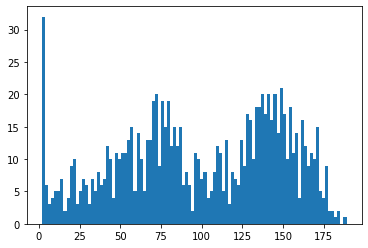

In [8]:
# TODO Visualize the length of the reviews in your dataset
def count_words(string):
    return len(string.split())

review_lengths = np.vectorize(count_words)(data['description_en'])

a = plt.hist(review_lengths, bins = 100)
plt.show()

In [9]:
%tensorflow_version 1.x
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
ids = np.stack(input_ids)
labels = np.stack(labels)
masks = np.stack(attention_masks)

## Create DataLoader

You can use `TensorDataset`, `torch.from_numpy(...)`, and `DataLoader(...)` to create Dataloaders for your dataset holding features, labels and attention masks. Make sure to shuffle your training data. Is shuffling required for the validation and test data?

In [15]:
# TODO
# create dataloaders
from torch.utils.data import TensorDataset, DataLoader
dataset = TensorDataset(torch.from_numpy(ids), torch.from_numpy(labels), torch.from_numpy(masks))
dataloader = DataLoader(dataset, shuffle=False, num_workers=2, batch_size=128)

# Generate Embeddings

In [16]:
# load model
sys.path.append("/content/airbnb_price/models")
from language_model import LanguageBertNet
model = LanguageBertNet(fine_tune=True, with_attention_masks=True)
path = "/content/drive/MyDrive/Colab/airbnb/data/logs/description/best/checkpoints/checkpoint.pt"
model.load_state_dict(torch.load(path))
model = model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
# generate embeddings
from tqdm import tqdm
embeddings = torch.empty((len(dataset), 100))
model.eval()
start = 0
indices = []
with torch.no_grad():
    for ids, index, masks in tqdm(dataloader):
        ids, masks = ids.to(device), masks.to(device)
        embedding = model.genembeddings(ids, masks)
        embedding = embedding.detach().cpu()
        stop = start + len(ids)
        embeddings[start:stop] = embedding
        start = stop
        indices = indices + list(index.numpy())

100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


In [19]:
# save embeddings in pandas dataframe
embeddings[embeddings < 0] = 0
df = pd.Series(embeddings.numpy().tolist(), name="descriptions", index=indices)
path = "/content/drive/MyDrive/Colab/airbnb/munich/embeddings/descriptions.pickle"
df.to_pickle(path)